In [1]:
### Opening nxs

import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d.nxs"
dark_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_dark.nxs"
flat_paths = [r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_ref.nxs", 
              r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\pre_ref.nxs"]

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)
print("Dark shape:", dark.shape)

flat = []
for path in flat_paths:
    with h5py.File(path, 'r') as file:
        flat_key = find_datasets_with_dim_3(file)[0][0]
        flat.append(np.mean(np.array(file[flat_key]), axis=0))
flat = np.mean(np.array(flat), axis=0)
print("Flat shape:", flat.shape)

Projections shape: (2850, 1200, 1472)
Dark shape: (1200, 1472)
Flat shape: (1200, 1472)


In [2]:
viewer = napari.Viewer()
viewer.add_image(projs, name='Projections')

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Projections' at 0x1f62f285580>

In [1]:
import numpy as np

projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_projs.npy")
projs = np.swapaxes(projs, 0, 1)
print("Projections shape:", projs.shape)
dark = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_darks.npy")
dark = np.mean(dark, axis=1)
print("Dark shape:", dark.shape)
flat = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_whites.npy")
flat = np.mean(flat, axis=1)
print("Flat shape:", flat.shape)

Projections shape: (3600, 1548, 2045)
Dark shape: (1548, 2045)
Flat shape: (1548, 2045)


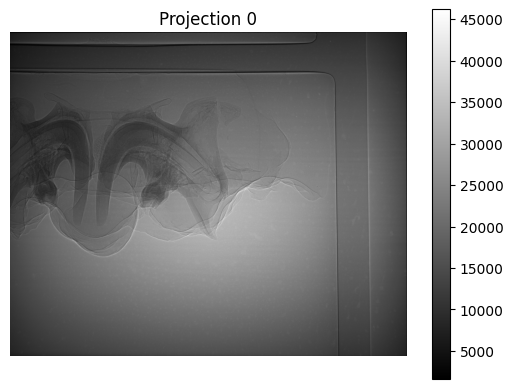

In [3]:
def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

display_slice(projs[0], title='Projection 0', cmap='gray', colorbar=True)

In [31]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)
print("Angle padding:", angle_padding)

CoR: 335.787505068283
Angle padding: 0.1264044943820224


delta/beta: 600.0


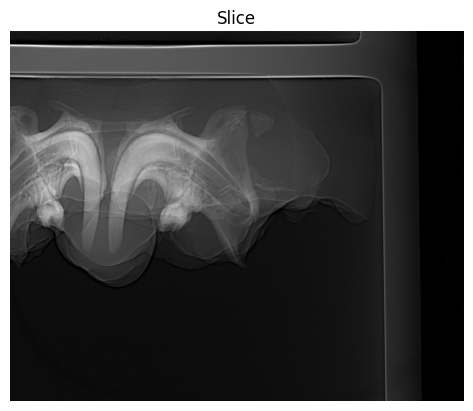

<Image layer 'Processed Projections' at 0x1f6b26ff8f0>

In [17]:
### Testing Paganin

import math
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from numpy import pi
import napari
import matplotlib.pyplot as plt
import cupy as cp

def keVtoLambda(energy_kev):
    """
    Convert energy in keV to wavelength in m.

    Parameters
    ----------
    energy_kev : float
        Energy in keV

    Returns
    -------
    float
        Wavelength in m
    """
    h = 6.58211928e-19  # keV.s
    c = 299792458  # m/s
    return h * c / energy_kev

def flatfield_correction(proj, white, dark):
    """
    Apply flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct
    white : 2D numpy array
        Whitefield image
    dark : 2D numpy array
        Darkfield image

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """
    numerator = abs(proj - dark)
    denominator = abs(white - dark)

    denominator[denominator == 0] = 1e-6

    return numerator / denominator


def get_padding_size(image, energy, effective_pixel_size, distance):
    """
    Calculate the padding size for a 2D image.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    n_margin : int
        Padding size.
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)

    # Calculate the padding size
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size**2))
    
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin

    nx_padded = 2 ** math.ceil(math.log2(nx_margin))
    ny_padded = 2 ** math.ceil(math.log2(ny_margin))


    return nx_padded, ny_padded

def padding(image, energy, effective_pixel_size, distance):
    """
    Pad a 2D image to avoid edge artifacts during phase retrieval with the closest value.

    Parameters
    ----------
    image : numpy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    padded_image : numpy.ndarray
        Padded image.
    """
    
    ny, nx = image.shape
    nx_padded, ny_padded = get_padding_size(image, energy, effective_pixel_size, distance)

    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left

    return cp.pad(image, ((top, bottom), (left, right)), mode='reflect'), ny_padded, nx_padded

def paganin_filter(sample_images, energy_kev, pixel_size, delta_beta, dist_object_detector, beta=1e-10):
    """
    Apply the Paganin filter to an image.

    Parameters
    ----------
    sample_images : numpy.ndarray
        Image to filter.
    energy_kev : float
        Energy of the X-ray beam (keV).
    pixel_size : float
        Effective pixel size of the detector (m).
    delta_beta : float
        Delta over beta value.
    dist_object_detector : float
        Distance between the object and the detector (m).
    beta : float
        Beta value for phase retrieval.

    Returns
    -------
    img_thickness : numpy.ndarray
        Filtered image.
    """
    lambda_energy = keVtoLambda(energy_kev)
    pix_size = pixel_size

    waveNumber = 2 * pi / lambda_energy

    mu = 2 * beta * waveNumber

    fftNum = cp.fft.fftshift(cp.fft.fft2(sample_images))
    Nx, Ny = fftNum.shape

    u = cp.fft.fftfreq(Nx, d=pix_size)
    v = cp.fft.fftfreq(Ny, d=pix_size)

    u, v = cp.meshgrid(cp.arange(0,Nx), cp.arange(0,Ny))
    u = u - (Nx/2)
    v = v - (Ny/2)
    u_m = u / (Nx * pix_size) 
    v_m = v / (Ny * pix_size)
    uv_sqrd = cp.transpose(u_m**2 + v_m**2)

    denominator = 1 + pi * delta_beta * dist_object_detector * lambda_energy * uv_sqrd
    denominator[denominator == 0] = cp.finfo(float).eps

    tmpThickness = cp.fft.ifft2(cp.fft.ifftshift(fftNum / denominator))
    img_thickness = cp.real(tmpThickness)
    img_thickness = -cp.asnumpy(cp.log(img_thickness) / mu) * 1e6

    img_thickness[img_thickness <= 0] = 0.000000000001

    return img_thickness


def process_projection(proj, nx, ny, white, dark, energy, effective_pixel_size, distance, beta, delta, pixel_size):
        """
        Process a single projection image.

        Parameters
        ----------
        proj : numpy.ndarray
            Projection image.
        nx : int
            Width of the image.
        ny : int
            Height of the image.
        white : numpy.ndarray
            Whitefield image.
        dark : numpy.ndarray
            Darkfield image.
        energy : float
            Energy of the X-ray beam (keV).
        effective_pixel_size : float
            Effective pixel size of the detector (m).
        distance : float
            Distance between the object and the detector (m).
        beta : float
            Beta value for phase retrieval.
        delta : float
            Delta value for phase retrieval.
        pixel_size : float
            Detector pixel size (m).

        Returns
        -------
        numpy.ndarray
            Processed image.
        """
        
        corrected_proj = flatfield_correction(cp.asarray(proj), cp.asarray(white), cp.asarray(dark))
        padded_proj, ny_padded, nx_padded = padding(corrected_proj, energy, effective_pixel_size, distance)
        retrieved_proj = paganin_filter(padded_proj, energy, pixel_size, delta/beta, distance, beta)
        x_margin = abs(nx_padded - nx) // 2
        y_margin = abs(ny_padded - ny) // 2

        return retrieved_proj[x_margin:x_margin+nx, y_margin:y_margin+ny]


energy = 40
effective_pixel_size = 10.4e-6 
distance = 1.2
pixel_size = 12e-6
delta = 7.8e-7
beta = 1.3e-9

nx = projs.shape[1]
ny = projs.shape[2]

print("delta/beta:", delta/beta)

proj = process_projection(projs[0], 
                          nx, 
                          ny, 
                            flat,
                            dark,
                          energy, 
                          effective_pixel_size, 
                          distance, 
                          beta, 
                          delta, 
                          pixel_size)
display_slice(proj)

viewer = napari.Viewer()
viewer.add_image(proj, name='Processed Projections')

100%|██████████| 2850/2850 [03:48<00:00, 12.47it/s]


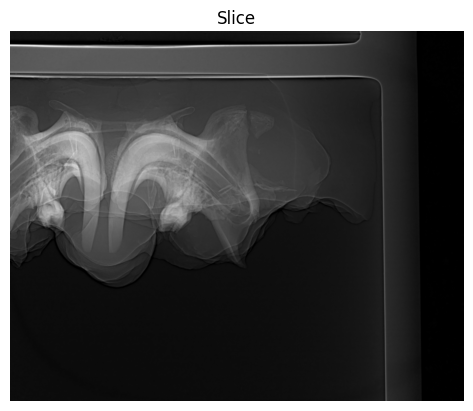

In [18]:
### Apply Paganin to all projections

from tqdm import tqdm
from joblib import Parallel, delayed

retrieved_projs = np.zeros_like(projs)
i = 0
for proj in tqdm(projs):
    retrieved_projs[i] = process_projection(proj, nx, ny, flat, dark, energy, effective_pixel_size, distance, beta, delta, pixel_size)
    i += 1

display_slice(retrieved_projs[0])

In [19]:
import napari

napari.view_image(retrieved_projs)

Viewer(camera=Camera(center=(0.0, 599.5, 735.5), zoom=0.3872282608695652, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1424.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=2849.0, step=1.0), RangeTuple(start=0.0, stop=1199.0, step=1.0), RangeTuple(start=0.0, stop=1471.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(1424.0, 599.0, 735.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'retrieved_projs' at 0x1f6bb8ba3f0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll 

In [20]:
### Double Flatfield Correction

def double_flatfield_correction(projs):
    """
    Apply double flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """

    mean_proj = np.mean(projs, axis=0)

    mean_proj[mean_proj == 0] = 1e-6

    I_corr = projs / mean_proj

    return I_corr


double_flatfield_projs = double_flatfield_correction(retrieved_projs)


In [ ]:
min = np.min(double_flatfield_projs)
max = np.max(double_flatfield_projs)

print(min, max)

normed_projs = (double_flatfield_projs - min) / (max - min)

In [ ]:
from tqdm import tqdm

def normalize_proj_mean(projs):

    global_mean = np.mean([np.mean(proj) for proj in projs])
    print("Global mean:", global_mean)

    normalized_proj = []
    for proj in tqdm(projs, desc="Normalizing projections"):
        mean = np.mean(proj)
        if mean == 0:
            mean = 1
        normalized_proj.append(proj * global_mean / mean)

    return np.array(normalized_proj)

normed_projs = normalize_proj_mean(double_flatfield_projs)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(double_flatfield_projs, name='Projections')
viewer.add_image(normed_projs, name='Normed Projections')

In [32]:
### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos
sinogram = create_sinogram(double_flatfield_projs, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

Creating sinograms: 100%|██████████| 1200/1200 [00:04<00:00, 289.60it/s]


Sinogram shape: (1200, 1425, 2272)


In [12]:
import napari

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Sinogram')

<Image layer 'Sinogram' at 0x23a7d2071d0>

In [ ]:
import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\test2.tif", sinogram[50].astype(np.float32), imagej=True)

In [33]:
import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)


Angles shape: [0.00000000e+00 2.20462642e-03 4.40925285e-03 ... 3.13497877e+00
 3.13718340e+00 3.13938803e+00]


In [34]:
### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

reconstruction = np.array(Parallel(n_jobs=-1)(
    delayed(reconstruct_from_sinogram_slice)(sinogram[i], angles) 
    for i in tqdm(range(sinogram.shape[0]))
))
print("Reconstruction shape:", reconstruction.shape)

100%|██████████| 1200/1200 [00:54<00:00, 21.93it/s]


Reconstruction shape: (1200, 2272, 2272)


In [35]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction')

<Image layer 'Reconstruction' at 0x1f6bb8fe780>

In [ ]:
### Save tiff format

import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\tooth.tif", reconstruction.astype(np.float32), imagej=True)